In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from Gauss_Newton import GaussNewton
from Levenberg_Marquardt import LevenbergMarquardt

In [2]:
# Read mnist data from the mat file
mnist_data = scipy.io.loadmat("mnist2.mat")
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])
d1,d2,N = np.shape(imgs_train)

In [3]:
# Select images of 1 and 7
Itrain_1 = np.where(labels_train == 1)
Itrain_7 = np.where(labels_train == 7)
Itest_1 = np.where(labels_test == 1)
Itest_7 = np.where(labels_test == 7)
imgs_train_1 = np.squeeze(imgs_train[:,:,Itrain_1])
imgs_train_7 = np.squeeze(imgs_train[:,:,Itrain_7])
imgs_test_1 = np.squeeze(imgs_test[:,:,Itest_1])
imgs_test_7 = np.squeeze(imgs_test[:,:,Itest_7])
Ntrain_1 = np.size(Itrain_1)
Ntrain_7 = np.size(Itrain_7)
Ntest_1 = np.size(Itest_1)
Ntest_7 = np.size(Itest_7)

In [4]:
# prepare labels for the train and test sets: ones have label 1, sevens have label -1
Ntrain = Ntrain_1 + Ntrain_7
Ntest = Ntest_1 + Ntest_7
lbl_train = np.ones((Ntrain,))
lbl_train[Ntrain_1:] = -1
lbl_test = np.ones((Ntest,))
lbl_test[Ntest_1:] = -1

In [5]:
# Use PCA to reduce the dimensionality to nPCA
def reduce_dim(NPCA = 20):
    dd = d1*d2
    X1 = np.zeros((Ntrain_1,dd))
    X7 = np.zeros((Ntrain_7,dd))
    for j in range(Ntrain_1):
        img = np.squeeze(imgs_train_1[:,:,j])
        X1[j,:] = np.reshape(img,(dd,))
    for j in range(Ntrain_7):
        img = np.squeeze(imgs_train_7[:,:,j])
        X7[j,:] = np.reshape(img,(dd,))
    X = np.concatenate((X1,X7),axis = 0)
    U,S,Vtrans = np.linalg.svd(X,full_matrices = False)
    V = np.transpose(Vtrans)
    Xtrain = np.matmul(X,V[:,:NPCA])
    # Prepare the test set
    X1test = np.zeros((Ntest_1,dd))
    X7test = np.zeros((Ntest_7,dd))
    for j in range(Ntest_1):
        img = np.squeeze(imgs_test_1[:,:,j])
        X1test[j,:] = np.reshape(img,(dd,))
    for j in range(Ntest_7):
        img = np.squeeze(imgs_test_7[:,:,j])
        X7test[j,:] = np.reshape(img,(dd,))
    Xtest = np.concatenate((X1test,X7test),axis = 0)
    Xtest = np.matmul(Xtest,V[:,:NPCA])
    return Xtrain,Xtest,NPCA

In [6]:
# Define functions for finding the optimal dividing surface
def logloss_quadratic(X,y,w):
    return 0.5*np.sum((np.log(1. + np.exp(-myquadratic(X,y,w))))**2)

def Res_and_Jac(X,y,w):
    # the vector of residuals r
    aux = np.exp(-myquadratic(X,y,w))
    r = np.log(1. + aux)
    # the Jacobian matrix J[i,j] = dr[i]/dx[j]
    a = -aux/(1. + aux)
    n,d = np.shape(X)
    d2 = d*d
    ya = y*a
    qterm = np.zeros((n,d2))
    for k in range(n):
        xk = X[k,:]
        xx = np.outer(xk,xk)
        qterm[k,:] = np.reshape(xx,(np.size(xx),))
    J = np.concatenate((qterm,X,np.ones((n,1))),axis = 1)   
    for k in range(n):
        J[k,:] = J[k,:]*ya[k]
    return r,J

def myquadratic(X,y,w):
    d = np.size(X,axis = 1)
    d2 = d*d
    W = np.reshape(w[:d2],(d,d))
    v = w[d2:d2+d];
    b = w[-1]
    qterm = np.diag(X@W@np.transpose(X))
    q = y*qterm + (np.outer(y,np.ones((d,)))*X)@v + y*b
    return q

In [7]:
def Loss(r):
    return 0.5 * np.sum(r ** 2)  # 0.5*sum(r^2)

def SGD(Xtrain,lbl_train, x, ITER_MAX, TOL, batch_size=6500, step=1):
    Xtrain=Xtrain[0:13000]
    lbl_train=lbl_train[0:13000]
    lossvals = np.zeros(ITER_MAX)
    gradnormvals = np.zeros(ITER_MAX)
    grad = 1 #initialize to enter loop  
    iter = 0 #hacky: changed from 1 to 0
    idx = 0
    while np.linalg.norm(grad) > TOL and iter < ITER_MAX:
        permutation = np.random.permutation(Xtrain.shape[0])
        Xtrain_shuffled = Xtrain[permutation]
        lbl_train_shuffled = lbl_train[permutation]
        if (iter+1) % 10 ==0:
            print('reduced step', step/2)
            step /=2
        for i in range(0, Xtrain.shape[0], batch_size):
            X_batch = Xtrain_shuffled[i:i+batch_size]
            lbl_batch = lbl_train_shuffled[i:i+batch_size]
            
            r, J = Res_and_Jac(X_batch,lbl_batch,x)
            Bmatr = np.matmul(J.T, J) + (1.e-6) * np.eye(421) #todo:fix 421 hardcoding # B = J^\top J
            grad = np.matmul(J.T, r)
            p = (-1) * np.linalg.solve(Bmatr, grad)  # p = -Bmatr^{-1}grad
            # if i/batch_size * (iter+1) % 100 == 0: #todo: this expression relies on iter=0
            #     print('reduced step', step/2)
            #     step /=2
            # print(i * iter, step)
            x = x + step*p
            lossnew = Loss(r)
            lossvals[idx] = lossnew
            gradnormvals[idx] = np.linalg.norm(grad)
            idx = idx + 1
            if np.linalg.norm(grad) < TOL:
                break
            # if batch_size <999:
            #     pass
                # print( f"LM, i #{i}: loss = {lossnew:.4e}, gradnorm = {np.linalg.norm(grad):.4e}")

            
        # lossvals[iter] = lossnew
        # gradnormvals[iter] = np.linalg.norm(grad)
        # print(f"LM, iter #{iter}: loss = {lossvals[iter]:.4e}, gradnorm = {np.linalg.norm(grad):.4e}, step = {step:.4e}")
        iter = iter + 1
    print(f"SGD, iter #{idx-1}: loss = {lossvals[idx-1]:.4e}, gradnorm = {np.linalg.norm(grad):.4e}, step = {step:.4e}, batch_size = {batch_size}")
    return x, iter, lossvals[0:idx], gradnormvals[0:idx]

In [8]:
def classify():
    # Apply the learned classifier to the test set
    test0 = myquadratic(Xtrain,lbl_train,w)
    hits = np.argwhere(test0 > 0)
    misses = np.argwhere(test0 < 0)
    Nhits0 = np.size(hits)
    Nmisses0 = np.size(misses)
    # print(f"TRAIN SET: {Nhits0} are classified correctly, {Nmisses0} are misclassified")
    
    test = myquadratic(Xtest,lbl_test,w)
    hits = np.argwhere(test > 0)
    misses = np.argwhere(test < 0)
    Nhits = np.size(hits)
    Nmisses = np.size(misses) #todo count misses 
    print(f"TEST SET: {Nmisses} are misclassified")
    misses = np.squeeze(misses)
    # print("Misses in the test set: ",misses)
    return Nmisses

In [9]:
def plot_gn(y_axis, y_label):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 16})
    plt.plot(y_axis)
    plt.xlabel("Iteration #")
    plt.ylabel(y_label)
    plt.yscale("log")
    plt.show()
def plot_sgd(y_axis, y_label, batch_size):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 16})
    plt.plot(y_axis)
    plt.xlabel("# of weight matrix updates")
    plt.ylabel(y_label)
    plt.yscale("log")
    plt.title(f"Batch size: {batch_size}")
    plt.show()

In [10]:
# Call Levenberg-Marquardt with varying number of PCAs
NPCA_vals=[2,4,8,16,22]
Nmisses_vals = np.zeros(len(NPCA_vals))
for idx, NPCA in enumerate(NPCA_vals): 
    print('NPCA:',NPCA)
    Xtrain,Xtest,d = reduce_dim(NPCA)
    d = NPCA
    def r_and_J(w):
        return Res_and_Jac(Xtrain,lbl_train,w)
    # The quadratic surface is of the form x^\top W x + v x + b 
    # The total number of parameters in W,v,b is d^2 + d + 1
    # The initial guess: all parameters are ones
    w = np.ones((d*d + d + 1,))
    iter_max = 600
    tol = 1e-3
    w,Niter,Loss_vals,gradnorm_vals = LevenbergMarquardt(r_and_J,w,iter_max,tol)
    Nmisses_vals[idx] = classify()
    print('--------------------------------------------')

NPCA: 2
LM, iter #13: loss = 647.0452928516877, gradnorm = 1.9922e+02, rho = 1.6405e-01, R = 1.5625e-02 , improvement = 5.6698e-02
TEST SET: 114 are misclassified
--------------------------------------------
NPCA: 4
LM, iter #11: loss = 277.1016007206424, gradnorm = 1.7826e+02, rho = 1.1784e-01, R = 2.5000e-01 , improvement = 8.2685e-02
TEST SET: 33 are misclassified
--------------------------------------------
NPCA: 8
LM, iter #18: loss = 119.45836335146372, gradnorm = 2.1072e+01, rho = 1.7763e-01, R = 2.5000e-01 , improvement = 3.8252e-02
TEST SET: 24 are misclassified
--------------------------------------------
NPCA: 16
LM, iter #42: loss = 0.45556944517952025, gradnorm = 8.6920e-02, rho = 9.5827e-01, R = 1.0000e+00 , improvement = 9.5380e-02
TEST SET: 17 are misclassified
--------------------------------------------
NPCA: 22
LM, iter #33: loss = 0.10181960244386076, gradnorm = 6.1764e-02, rho = 8.8584e-01, R = 1.0000e+00 , improvement = 8.3295e-02
TEST SET: 9 are misclassified
---

# PCAs: [2, 4, 8, 16, 22]
Misses: [114.  33.  24.  17.   9.]


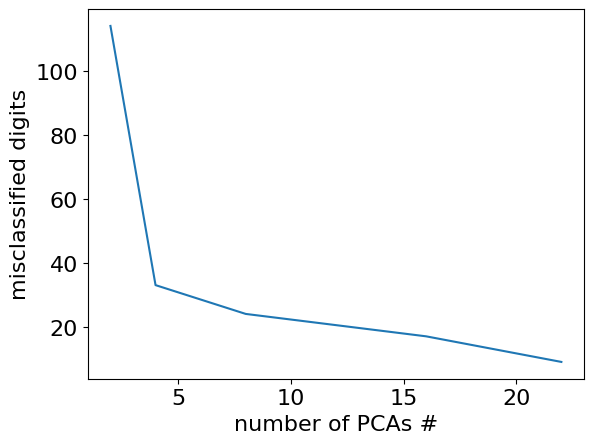

In [11]:
# Task 1 - Plot misclassified digits vs the number of PCAs
fig = plt.figure()
plt.rcParams.update({'font.size': 16})
print('# PCAs:',NPCA_vals)
print('Misses:', Nmisses_vals)
plt.plot(NPCA_vals, Nmisses_vals)
plt.xlabel("number of PCAs #")
plt.ylabel("misclassified digits")
plt.show()
# plt.yscale("log")

GN, iter #13: loss = 9.0963e-06, gradnorm = 1.5292e-04


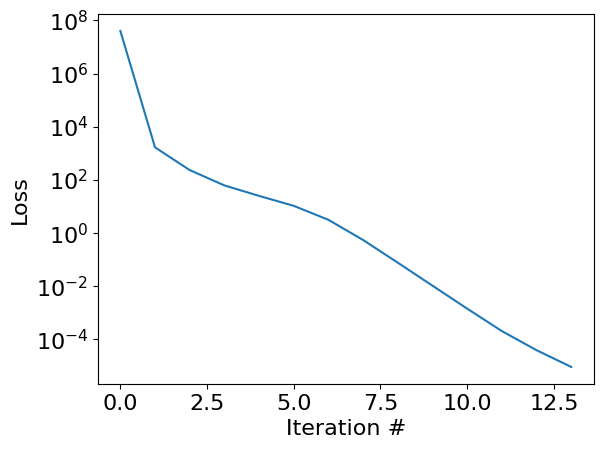

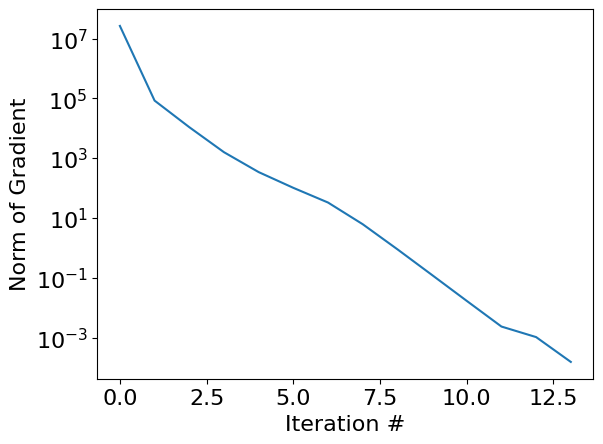

In [12]:
# Task 2 - Call Gauss_Newton
NPCA=20#,10,15,20,25,30]
Xtrain,Xtest,d = reduce_dim(NPCA)
d = NPCA
def r_and_J(w):
    return Res_and_Jac(Xtrain,lbl_train,w)
# The initial guess: all parameters are ones
w = np.ones((d*d + d + 1,))
iter_max = 600
tol = 1e-3
w,Niter,Loss_vals,gradnorm_vals = GaussNewton(r_and_J,w,iter_max,tol)
plot_gn(Loss_vals, 'Loss')
plot_gn(gradnorm_vals, 'Norm of Gradient')

SGD, iter #18: loss = 7.2961e-17, gradnorm = 7.1677e-15, step = 1.0000e+00, batch_size = 10
TEST SET: 79 are misclassified


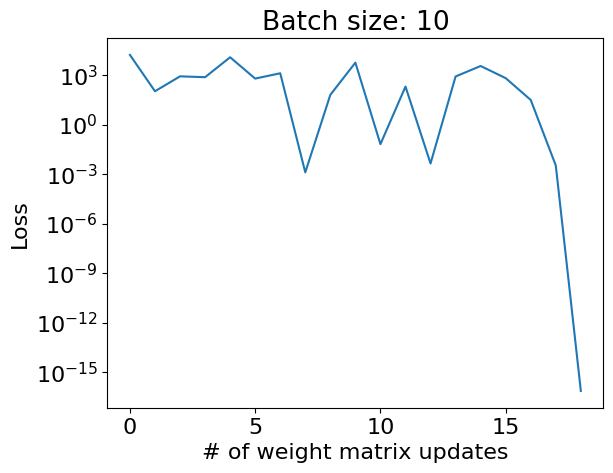

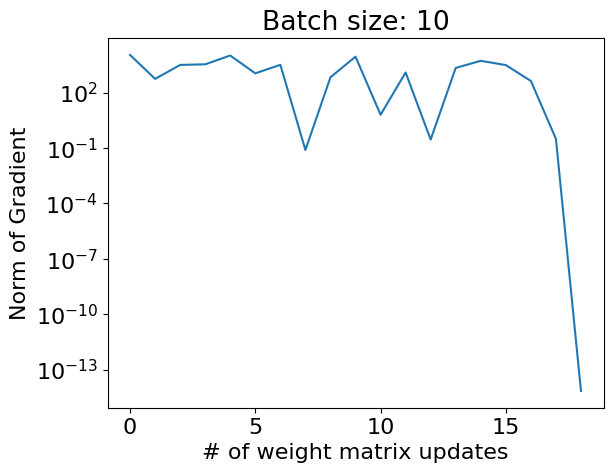

SGD, iter #14: loss = 3.3159e-12, gradnorm = 4.2716e-10, step = 1.0000e+00, batch_size = 25
TEST SET: 69 are misclassified


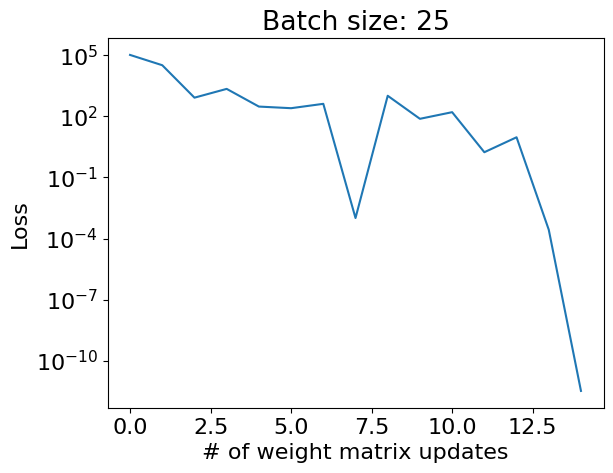

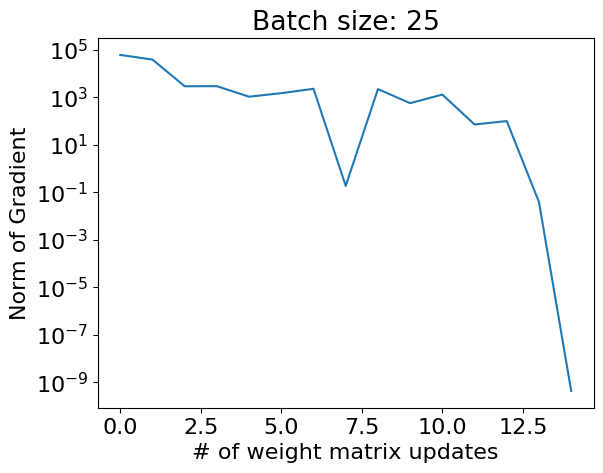

SGD, iter #44: loss = 8.7182e-15, gradnorm = 8.3484e-13, step = 1.0000e+00, batch_size = 50
TEST SET: 30 are misclassified


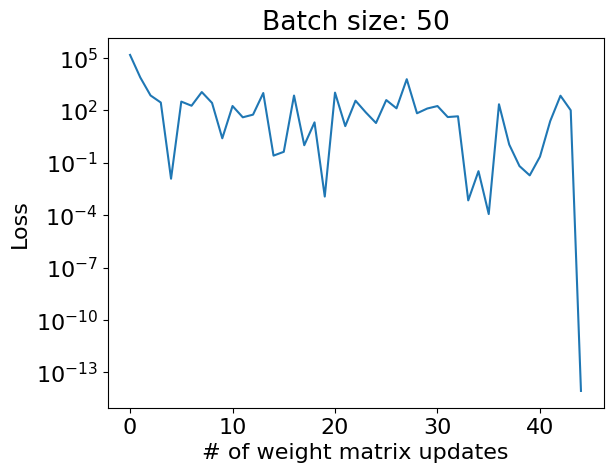

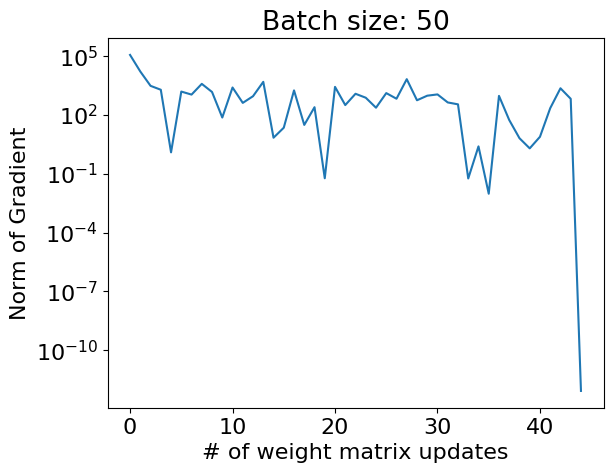

SGD, iter #17: loss = 1.0743e-05, gradnorm = 6.5588e-04, step = 1.0000e+00, batch_size = 100
TEST SET: 36 are misclassified


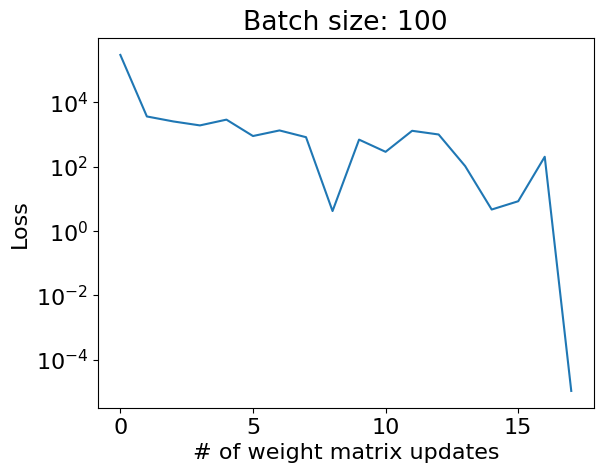

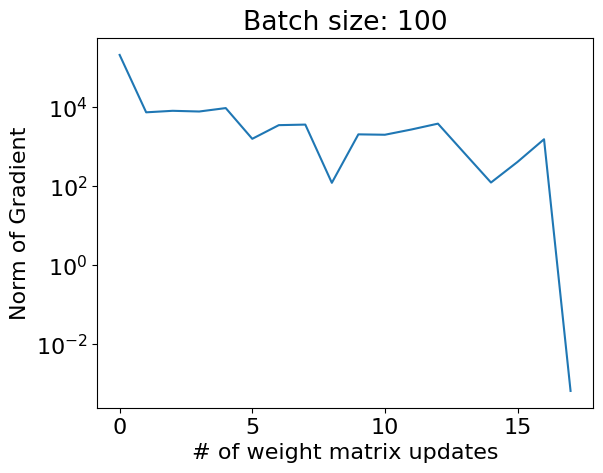

SGD, iter #19: loss = 6.6651e-06, gradnorm = 4.5691e-04, step = 1.0000e+00, batch_size = 250
TEST SET: 21 are misclassified


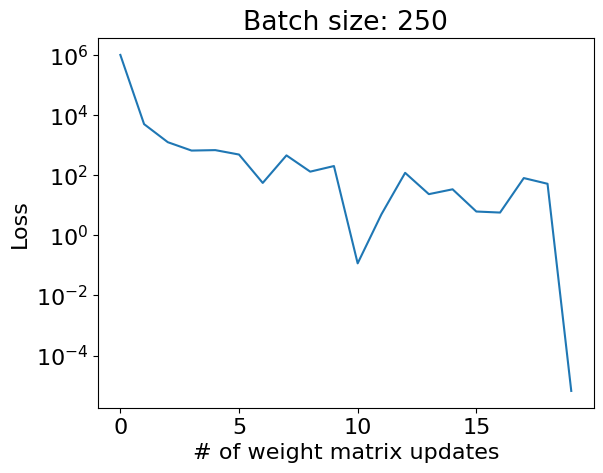

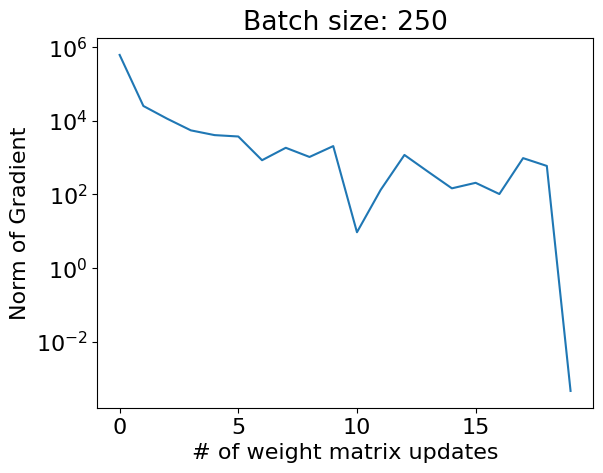

SGD, iter #140: loss = 1.3150e-05, gradnorm = 5.7082e-04, step = 1.0000e+00, batch_size = 500
TEST SET: 13 are misclassified


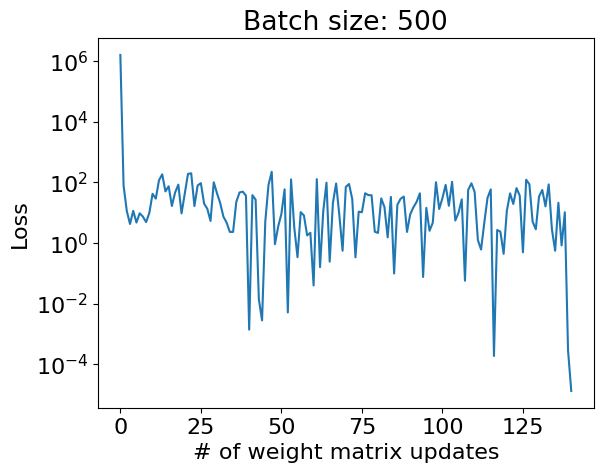

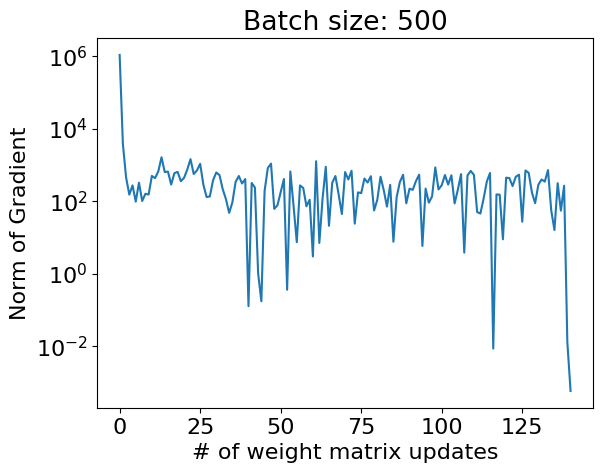

reduced step 0.5
reduced step 0.25
SGD, iter #362: loss = 4.1180e-08, gradnorm = 2.0393e-06, step = 2.5000e-01, batch_size = 1000
TEST SET: 9 are misclassified


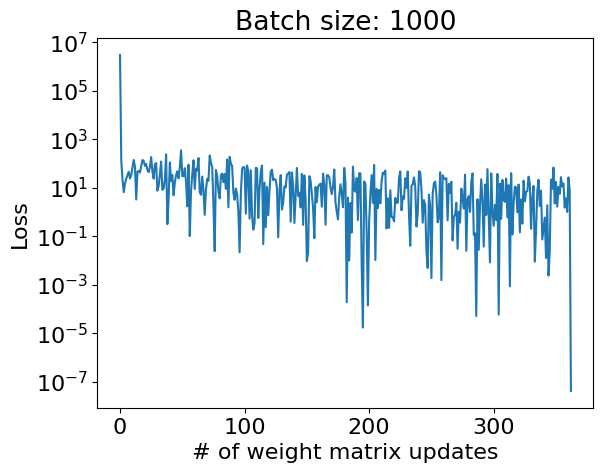

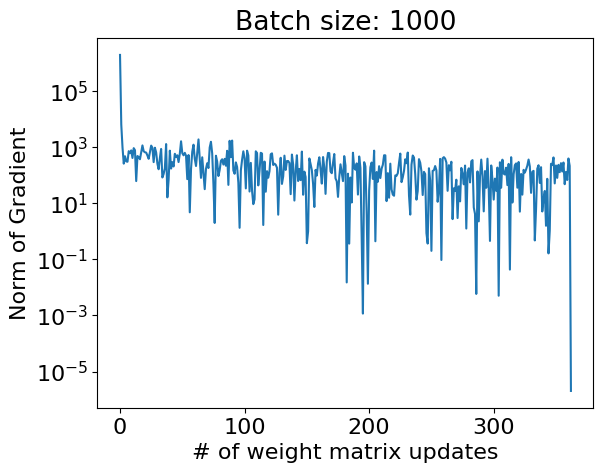

In [13]:
# Task 3 - Call SGD
NPCA=20
Xtrain,Xtest,d = reduce_dim(NPCA)
d = NPCA
def r_and_J(w):
    return Res_and_Jac(Xtrain,lbl_train,w)
iter_max = 600
tol = 1e-3
batch_size_list=[10,25,50,100,250,500,1000]
for batch_size in batch_size_list:
    w = np.ones((d*d + d + 1,))
    w,Niter,Loss_vals,gradnorm_vals = SGD(Xtrain,lbl_train,w,iter_max,tol, batch_size)
    classify()
    plot_sgd(Loss_vals, "Loss", batch_size)
    plot_sgd(gradnorm_vals, "Norm of Gradient", batch_size)
    
    # print('--------------------------------------------')
